# Modèle HarderLASSO linéaire (fonction de coût square-root $\ell_2$ et pénalité "Subbotin" $P_{\nu}$)

Je me repose uniquement sur l'article *"Training a neural network for data interpretation and better generalization: towards intelligent artificial intelligence"* de **Sylvain Sardy**, **Maxime van Custsem** et **Xiaoyu Ma**

In [3]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent.parent.parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

## Théorie

### Fondamentaux

On résout ce problème de minimisation :

$$\min_{\boldsymbol{\beta}^{(1)}\in\mathbb{R}^{\gamma_1},\boldsymbol{\beta}^{(2)}\in\mathbb{R}^{\gamma_2}}\mathcal{L}_n(\mu_{(\boldsymbol{\beta}^{(1)},\boldsymbol{\beta}^{(2)})};\mathbf{y},X)+\lambda P(\boldsymbol{\beta}^{(1)})$$

où 
- $P$ est une pénalité
- $\lambda$ le coefficient de pénalisation
- $\mathcal{L}_n$ est une fonction de coût
  - avec $\mu_{(\boldsymbol{\beta}^{(1)},\boldsymbol{\beta}^{(2)})}$ le "Learner".

On remarque ici que seul les paramètres $\boldsymbol{\beta}^{(2)}$ sont pénalisés. On a $\gamma_1 + \gamma_2 = p$.



Seulement pas toutes les paires ($\mathcal{L}_n$, $P$) sont QUT-compatible !

On prends dans notre cas le couple choisis ici pour la méthode HarderLASSO :

$$ \boxed{\text{HarderLASSO} := (P_{\nu}, \|\cdot\|_2)}$$ 

En plus pour n'importe quel valeurs de $\nu$, $\lambda_{\alpha}^{\mathrm{QUT}}(X)$ est le même !

### $P_{\nu}$ ?

$$P_\nu(\boldsymbol{\beta})=\sum_{j=1}^p\rho_\nu(\boldsymbol{\beta}_j)\quad\mathrm{avec}\quad\rho_\nu(\boldsymbol{\beta})=\frac{\|\boldsymbol{\beta}\|_2}{1+\|\boldsymbol{\beta}\|_2^{1-\nu}}$$

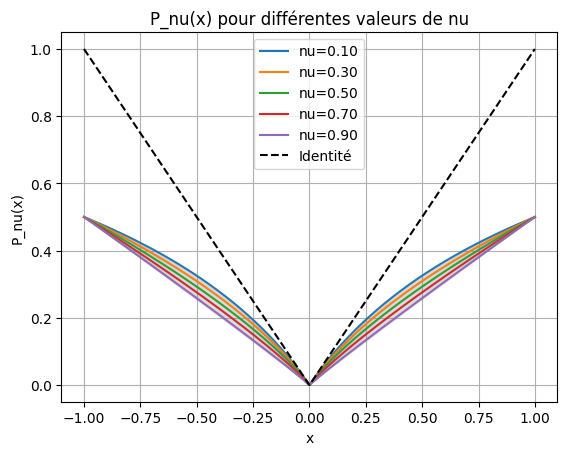

In [2]:
import numpy as np
import matplotlib.pyplot as plt

list_nu = np.arange(0.1, 1, 0.05)
x_list = np.linspace(-1, 1, 1000)

def P_nu(x, nu):
    x = np.asarray(x)
    norm_x = np.abs(x)
    rho = norm_x / (1 + norm_x**(1 - nu))
    return np.sum(rho)

# Afficher la courbe pour quelques valeurs de nu seulement dans la légende
nu_legende = [0.1, 0.3, 0.5, 0.7, 0.9]
for nu_val in list_nu:
    if np.round(nu_val, 2) in nu_legende:
        plt.plot(x_list, [P_nu(x, nu_val) for x in x_list], label=f"nu={nu_val:.2f}")
    else:
        plt.plot(x_list, [P_nu(x, nu_val) for x in x_list], color='gray', alpha=0.3, linewidth=0.8)

plt.plot(x_list, np.abs(x_list), '--', color='black', label="Identité")
plt.xlabel("x")
plt.ylabel("P_nu(x)")
plt.title("P_nu(x) pour différentes valeurs de nu")
plt.legend()
plt.grid(True)
plt.show()

### $\lambda_0(\cdot)$ ?

##### **Cas : Régression linéaire avec fonction coût square-root et pénalité $P_\nu$** ($\xi = \beta$)

On cherche pour quel $\lambda$ la solution du problème  
$$
\hat{\beta}_\lambda(y) = \arg\min_{\beta} \|y - X\beta\|_2 + \lambda P_\nu(\beta)
$$  
devient nulle, avec  
$$
P_\nu(\beta) = \sum_{j=1}^p \frac{|\beta_j|}{1 + |\beta_j|^{1 - \nu}} \quad \text{avec } \nu \in (0,1]
$$

On note $r = y - X\beta$. La fonction $\beta \mapsto \|r\|_2$ n'est pas différentiable partout (au point $r = 0$), mais elle est sub-différentiable sur $\mathbb{R}^n \setminus \{0\}$.

On considère la sous-différentielle du critère au point $\beta = 0$ :
$$
\partial \left( \|y - X\beta\|_2 + \lambda P_\nu(\beta) \right) \quad \text{au point } \beta = 0
$$

Comme $\beta = 0$, on a $r = y$, donc :
$$
\partial \left( \|y - X\beta\|_2 \right) = -\frac{X^\top y}{\|y\|_2} \quad \text{(valide si } y \neq 0\text{)}
$$

Concernant $P_\nu$, sa dérivée à droite en zéro vaut $1$ pour tout $\nu \in (0,1]$, donc :
$$
\partial P_\nu(\beta)\big|_{\beta = 0} = \{v \in \mathbb{R}^p : v_j \in [-1, 1] \text{ pour tout } j\}
$$

Pour que $\beta = 0$ soit une solution (minimum local), il faut :
$$
0 \in -\frac{X^\top y}{\|y\|_2} + \lambda \cdot \partial P_\nu(\beta)\big|_{\beta=0}
$$
soit :
$$
\frac{X^\top y}{\|y\|_2} \in \lambda \cdot \partial P_\nu(0)
$$

Donc chaque composante de $\frac{X^\top y}{\|y\|_2}$ doit être dans $[-\lambda, \lambda]$ :
$$
\left\| \frac{X^\top y}{\|y\|_2} \right\|_\infty \leq \lambda
$$

Ce qui donne :
$$
\lambda_0^{\text{local}}(y) = \left\| \frac{X^\top y}{\|y\|_2} \right\|_\infty
$$

Cette forme a l’avantage d’être **pivotal**, c’est-à-dire que $\lambda_0^{\text{local}}(y)$ **ne dépend pas** du bruit $\sigma$, et est donc directement exploitable pour la sélection via le QUT. C'est la même que pour le modèle Square root avec pénalité $\ell_1$.

### $\lambda_\text{QUT}$ ?

On réutilise la même fonction que dans le cas square root avec pénalité $\ell_1$.

### Optimisation

La seul chose qui diffère ici c'est le calucl de mon proximal !

$$\mathrm{prox}_{\lambda\rho_\nu}(z)=\arg\min_\theta\frac{1}{2}(z-\theta)^2+\lambda\cdot\rho_\nu(\theta)$$

Or,

$$\eta_\lambda(y;\nu):=\arg\min_\theta\frac{1}{2}(y-\theta)^2+\lambda\cdot\rho_\nu(\theta)$$

Soient $\kappa$ et $\varphi$ telle que :
$$\kappa^{2-\nu}+2\kappa+\kappa^\nu+2\lambda(\nu-1)=0$$
et
$$\varphi=\frac{\kappa}{2}+\frac{\lambda}{1+\kappa^{1-\nu}}$$

On a donc
$$\mathrm{prox}_{\lambda\rho_\nu}(z) = \eta_\lambda(z;\nu)=\begin{cases}0&\text{si}\quad|z|\leq\varphi\\\text{solution de }\theta-z+\lambda\cdot\rho_\nu^{\prime}(\theta)=0&\mathrm{sinon}&\end{cases}$$

Pour trouver $\kappa$ j'utilise une dichotomie et pour $\varphi$ la méthode de newton-raphson

D'ailleurs on a

$$\rho_\nu^{\prime}(t)=\mathrm{sign}(t)\cdot\frac{1+\nu|t|^{1-\nu}}{(1+|t|^{1-\nu})^2}$$

$$\rho_\nu^{\prime\prime}(t)=\nu(1-\nu)\cdot\frac{|t|^{-\nu}}{(1+|t|^{1-\nu})^3}\quad\mathrm{pour~}t\neq0$$

#### TEST

**TEST pour comparer l'implémentation du proximal que je fais et celle de l'article :**

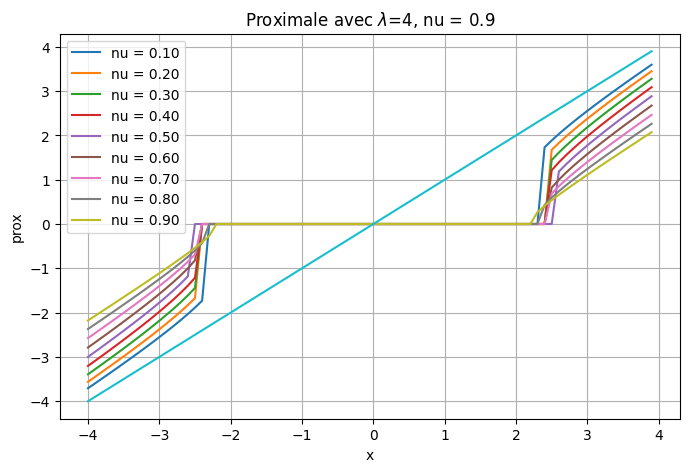

In [3]:
from linear_tools import dichotomie, newton
import numpy as np
import matplotlib.pyplot as plt

x_list = np.arange(-4, 4, 0.1)
lmbda = 4
verbose = False
list_nu = np.arange(0.1, 1, 0.1)

def F_jump(k, lmbda, nu):
        return k**(2 - nu) + 2*k + k**nu + 2 * lmbda * (nu - 1)

def rho_nu_prime(theta, nu):
    abs_theta = abs(theta)
    denom = (1 + abs_theta**(1 - nu))**2
    return np.sign(theta) * (1 + nu * abs_theta**(1 - nu)) / denom

def drho_nu_prime(theta, nu):
    abs_theta = abs(theta)
    num = nu * (1 - nu) * abs_theta**(-nu)
    denom = (1 + abs_theta**(1 - nu))**3
    return num / denom

def F_theta(theta, z, lmbda, nu):
    return theta - z + lmbda * rho_nu_prime(theta, nu)

def F_theta_prime(theta, z, lmbda, nu):
    return 1 + lmbda * drho_nu_prime(theta, nu)

plt.figure(figsize=(8, 5))

for nu in list_nu:

    kappa = dichotomie(F_jump, (lmbda, nu), a=1e-25, b=1e2, tol=1e-6)
    phi = 0.5 * kappa + lmbda / (1 + kappa**(1 - nu))

    if verbose:
        print(f"nu = {nu:.2f}")
        print("\t kappa : ", kappa)
        print("\t phi : ", phi)
        
    y = np.zeros_like(x_list)
    for i, x in enumerate(x_list):
        if abs(x) <= phi:
            y[i] = 0.0
        else:
            y[i] = newton(F_theta, F_theta_prime, F_args=(x, lmbda, nu), x0=x, tol=1e-6)

    plt.plot(x_list, y, label=f"nu = {nu:.2f}")

plt.plot(x_list, x_list)


plt.legend()
plt.title(f"Proximale avec $\lambda$={lmbda}, nu = {nu}")
plt.xlabel("x")
plt.ylabel("prox")
plt.grid(True)
plt.show()

## Simulations

In [1]:
n = 70
p = 250
list_s = range(0, 30)

sigma = 0.1
nu = 0.1

simu_iter=10
qut_iter=1000
max_iter=1000
tol=1e-8

seed=43

### HARDER LASSO avec ISTA backtracking

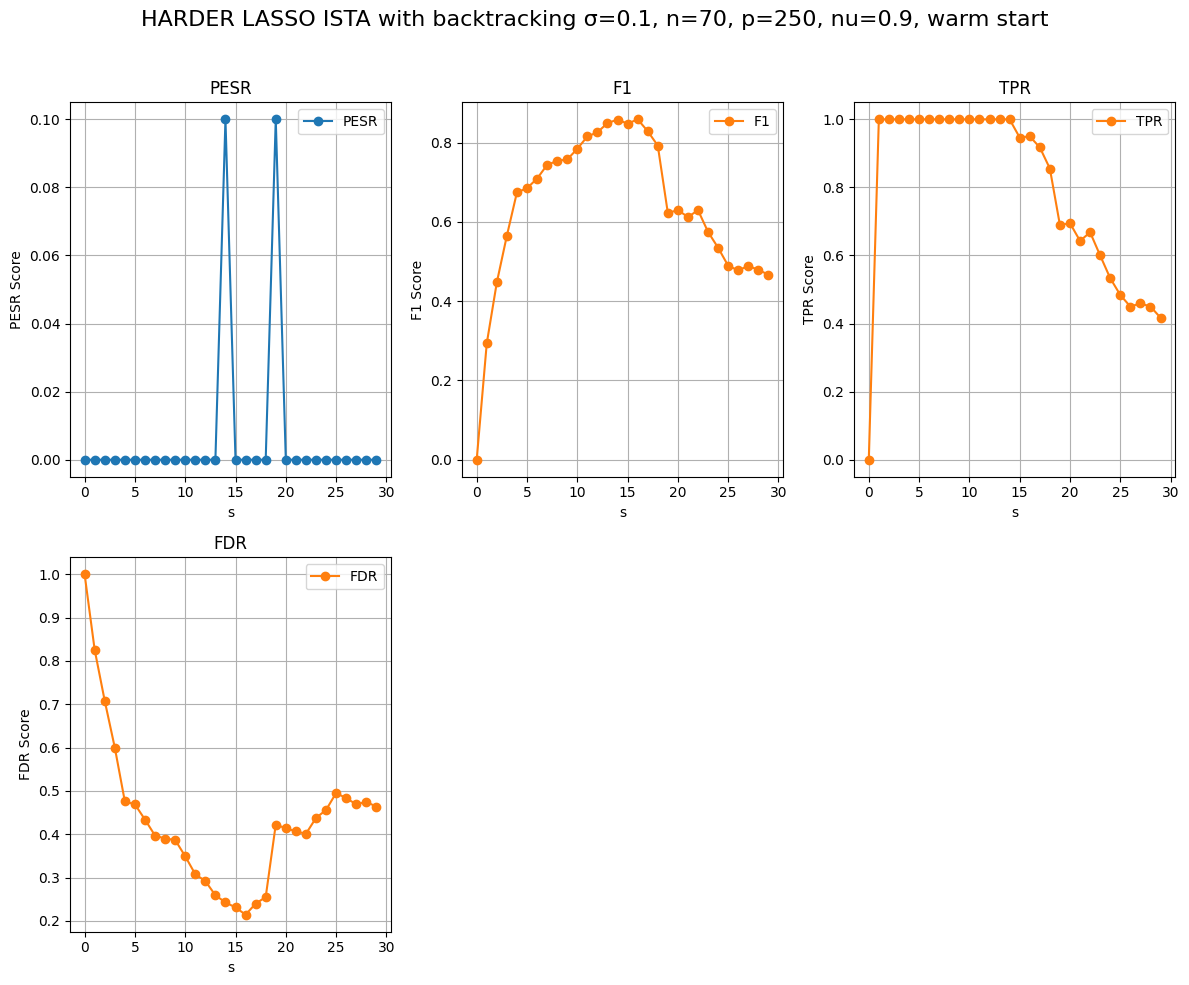

In [4]:
from simulations import SimulationHarderLassoIstaBacktracking

Sim = SimulationHarderLassoIstaBacktracking(
    n = n,
    p = p,
    list_s = list_s, 
    sigma = sigma,
    nu = None,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim.L0 = 0.1

Sim.run()

Sim.plot()

### Test de plusieurs valeurs de $\nu$ pour HARDER LASSO avec ISTA backtracking

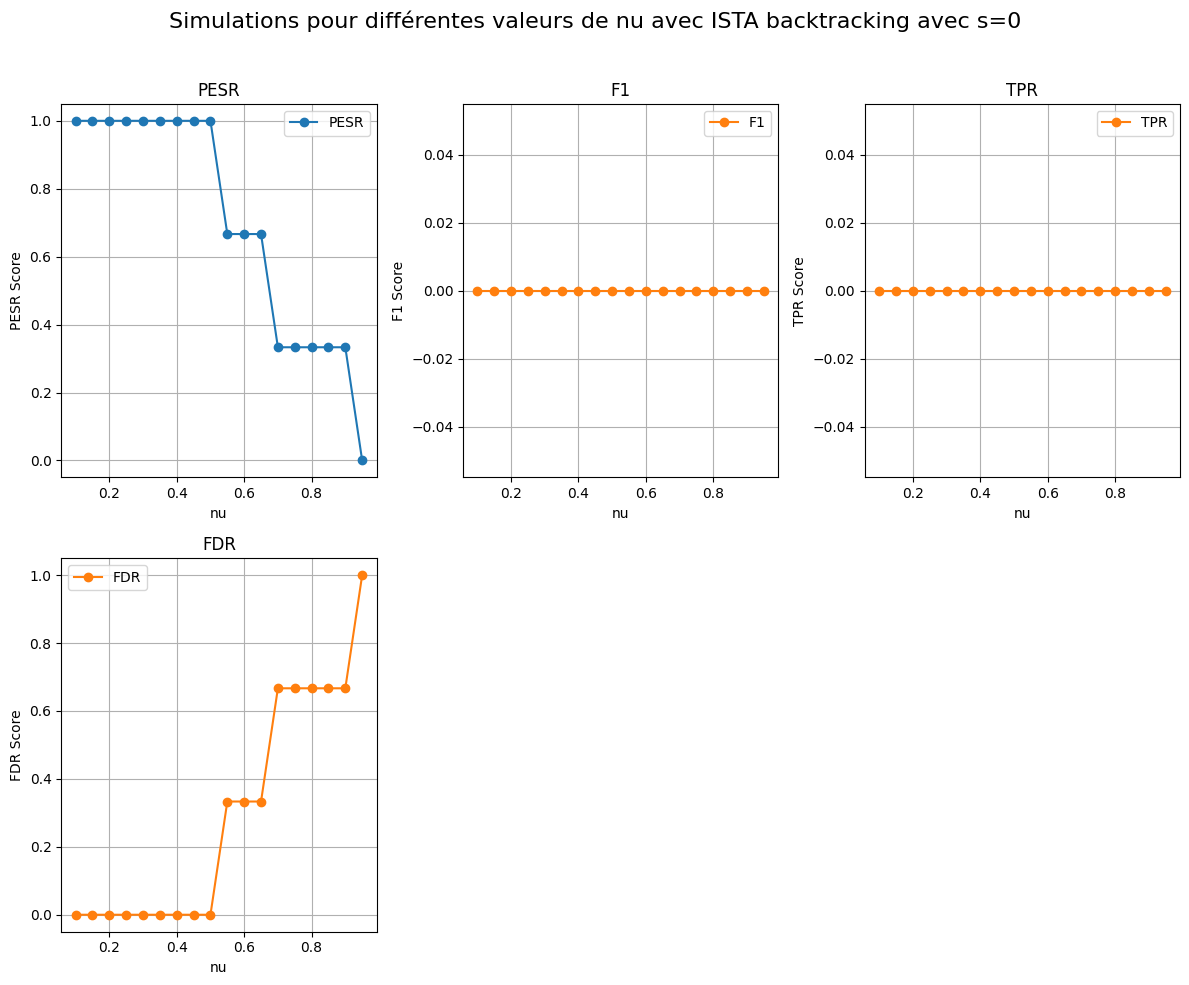

In [6]:
from simulations import SimulationHarderLassoIstaBacktracking
from linear_tools import plot_scores
import numpy as np

n = 70
p = 250
list_s = [0]
list_nu = np.arange(0.1, 1, 0.05)
simu_iter = 3
verbose=False

scores = {}

for nu in list_nu:
    
    if verbose: print(f"=> Simulation avec nu = {nu:.2f}")
    
    Sim = SimulationHarderLassoIstaBacktracking(
        n = n,
        p = p,
        list_s = list_s, 
        sigma = sigma,
        nu = nu,
        simu_iter = simu_iter,
        qut_iter = qut_iter,
        max_iter = max_iter,
        tol = tol,
        seed = seed,
        verbose=verbose
    )

    Sim.L0 = 0.1

    Sim.run()
    
    scores[f"nu = {nu}"] = Sim.score

score_flat = {}
for metric in ['pesr', 'f1', 'tpr', 'fdr']:
    score_flat[metric] = [np.mean(scores[f"nu = {nu}"][metric]) for nu in list_nu]

plot_scores(
    score=score_flat,
    x_range=list_nu,
    x_label="nu",
    title="Simulations pour différentes valeurs de nu avec ISTA backtracking avec s=0"
)

On remarque un problème lorsque \nu est proche de 1 ce qui ne devrait pas avoir lieu car en théorie le lambda_qut est bien choisi pour que à s=0 on obtienne 0.95 chance d'obtenir le bon modèle.